In [27]:
from typing import Callable, Tuple

import numpy as np
import pandas as pd
from numba import prange, njit, typed, types, set_num_threads
from tqdm.notebook import trange
from numpy.typing import NDArray
from numba import njit, prange
import matplotlib.pyplot as plt
from scipy import stats

from util import normalize_values, ideal_point_method, linear_convolution, little_law

In [2]:
def get_service_times() -> NDArray['float']:
    df = pd.read_csv('../data/service_times.csv')
    df.rename(columns={'TTI 0.95': 'service_time' }, inplace=True)
    df['service_time'] = df['service_time'].map(lambda time: float(time.replace('ms', '')))

    return np.array(df['service_time'])

In [3]:
service_times = get_service_times()

In [4]:
@njit
def arrive_cdf() -> float:
    return np.random.exponential(0.299)

@njit
def leave_cdf() -> float:
    return np.random.exponential(510)

@njit
def departure_cdf() -> float:
    return np.random.choice(service_times) * 0.95 / 4

In [5]:
@njit
def init_request_times_queues(n: int) -> list[list[float]]:
    request_times_queues = []
    for i in range(n):
        request_times_queues.append(np.empty(0, dtype=np.float64))

    return request_times_queues

@njit
def get_min_time_of_leave(
    request_times_queues: list[list[float]]
) -> (float, int, int):
    min_time_in_queue_indexes = np.full(len(request_times_queues), -1, dtype=np.int32)
    
    for i in range(len(request_times_queues)):
        min_time = np.inf
        for j in range(len(request_times_queues[i])):
            if request_times_queues[i][j] < min_time:
                min_time = request_times_queues[i][j]
                min_time_in_queue_indexes[i] = j

    min_time = np.inf
    min_time_index = -1
    queue_index = -1
    
    for q in range(len(request_times_queues)):
        min_time_in_queue_index = min_time_in_queue_indexes[q]
        if min_time_in_queue_index != -1 and request_times_queues[q][min_time_in_queue_index] < min_time:
            min_time = request_times_queues[q][min_time_in_queue_index]
            queue_index = q
            min_time_index = min_time_in_queue_index

    return min_time, queue_index, min_time_index

@njit
def get_queue_with_minimum_size(
    request_times_queues: list[list[float]]
) -> (int, int):
    min_size = np.inf
    queues = np.empty(0, dtype=np.int64)
    
    for i in range(len(request_times_queues)):
        size = len(request_times_queues[i])
        if size < min_size:
            min_size = size
            queues = np.array([i], dtype=np.int64)
        elif size == min_size:
            queues = np.append(queues, i)

    queue = int(np.random.choice(queues))

    return min_size, queue

@njit
def all_queues_are_full(
    N: int,
    request_times_queues: list[list[float]],
) -> bool:
    flag = True
    for queue in request_times_queues:
        if len(queue) < N:
            flag = False
            return flag

    return flag

In [6]:
@njit
def get_next_event(
    arrival_time: float,
    request_times_queues: list,
    departure_times: list,
) -> (float, str, int, int):
    event_type = 'ARRIVAL'
    min_index = -1
    queue_index = -1
    min_time = arrival_time

    min_departure_time_index = -1
    min_departure_time = np.inf
    for i in range(len(departure_times)):
        if departure_times[i] != -1 and departure_times[i] < min_departure_time:
            min_departure_time_index = i
            min_departure_time = departure_times[i]

    min_leave_time, leave_from_queue, min_leave_time_index = get_min_time_of_leave(request_times_queues)

    if min_departure_time < min_time:
        min_index = min_departure_time_index
        min_time = min_departure_time
        event_type = 'DEPARTURE'
    if min_leave_time < min_time:
        min_index = min_leave_time_index
        min_time = min_leave_time
        queue_index = leave_from_queue
        event_type = 'LEAVE'

    return min_time, event_type, queue_index, min_index

In [7]:
@njit
def arrival(
    time: float,
    num_in_system: int,
    num_total_requests: int,
    leave_indicator: int,
    request_times_queues: list[list[float]],
    departure_times: list[float],
    N: int
) -> (float, int, int, int, list[list[float]], list[float]):
    num_in_system += 1 # увеличиваем число запросов в системе
    num_total_requests += 1

    if all_queues_are_full(N, request_times_queues):
        num_in_system -= 1 # считаем, что заявка покинула систему
        leave_indicator += 1 # увеличиваем индикатор выхода из системы
    else:
        queue_size, queue = get_queue_with_minimum_size(request_times_queues) # выбираем очередь с наименьшим числом заявок
        if queue_size == 0 and departure_times[queue] == -1: # если выбранный прибор свободен
            mu = departure_cdf()
            departure_times[queue] = time
            departure_times[queue] = time + mu # планируем обработку запроса
        else:
            gamma = leave_cdf()
            request_times_queues[queue] = np.append(request_times_queues[queue], time + gamma) # планируем выход из системы
    
    alpha = arrive_cdf()
    time += alpha
    return time, num_in_system, num_total_requests, leave_indicator, request_times_queues, departure_times

@njit
def departure(
    time: float,
    queue: int,
    num_in_system: int,
    request_times_queues: list[list[float]],
    departure_times: list[float],
) -> (int, list[list[float]], list[float]):
    num_in_system -= 1 # запрос обработан - уменьшаем число запросов в системе
    
    if (len(request_times_queues[queue]) == 0): # если очередь пуста
        departure_times[queue] = -1
    else:        
        mu = departure_cdf()
        departure_times[queue] = time + mu # планируем обработку запроса
        request_times_queues[queue] = np.delete(request_times_queues[queue], 0)
    return num_in_system, request_times_queues, departure_times

@njit
def on_leave(
    queue: int,
    time_index: int,
    num_in_system: int,
    leave_indicator: int,
    request_times_queues: list[list[float]]
) -> (int, int, list[list[float]]):
    num_in_system -= 1 # запрос ушёл - уменьшаем число запросов в системе
    leave_indicator += 1 # увеличиваем индикатор выхода из системы
    
    request_times_queues[queue] = np.delete(request_times_queues[queue], time_index)

    return num_in_system, leave_indicator, request_times_queues

In [8]:
@njit
def update_area_num_in_system_stat(
    time: float,
    past_event_time: float,
    num_in_system: int,
    area_num_in_system: float
) -> (float, float):
    time_since_past_event = time - past_event_time
    past_event_time = time

    area_num_in_system += (num_in_system * time_since_past_event)
    return past_event_time, area_num_in_system

In [9]:
@njit
def num_in_system_iteration(
    T: float,
    n: int,
    N: int,
    return_value: str = 'average_requests_in_system',
) -> float:
    time = 0.0
    past_event_time = 0.0

    num_in_system = 0
    area_num_in_system: float = 0.0

    num_total_requests = 0
    leave_indicator = 0
    
    arrival_time = arrive_cdf()
    leave = leave_cdf()

    departure_times = np.full(n, -1, dtype=np.float64)
    request_times_queues = init_request_times_queues(n)
    
    while time < T:
        time, event_type, queue_index, time_index = get_next_event(arrival_time, request_times_queues, departure_times)
        past_event_time, area_num_in_system = update_area_num_in_system_stat(
            time,
            past_event_time,
            num_in_system,
            area_num_in_system
        )
        
        if event_type == 'ARRIVAL':
            arrival_time, num_in_system, num_total_requests, leave_indicator, request_times_queues, departure_times = arrival(
                time,
                num_in_system,
                num_total_requests,
                leave_indicator,
                request_times_queues,
                departure_times,
                N
            )
        elif event_type == 'DEPARTURE':
            num_in_system, request_times_queues, departure_times = departure(
                time,
                time_index,
                num_in_system,
                request_times_queues,
                departure_times
            )
        else:
            num_in_system, leave_indicator, request_times_queues = on_leave(
                queue_index,
                time_index,
                num_in_system,
                leave_indicator,
                request_times_queues
            )

    average_requests_in_system = area_num_in_system / time
    loss_probability = leave_indicator / num_total_requests

    if return_value == 'average_requests_in_system':
        return average_requests_in_system
    if return_value == 'loss_probability':
        return loss_probability

In [10]:
@njit(parallel=True)
def num_in_system_iteration_resolver(
    T: float,
    N: int,
    n: int,
    max_queue_size: int,
    x_betta: float,
    eps: float = 1e-3,
    return_value: str = 'average_requests_in_system'
) -> float:
    N_new = N
    N_old = 0

    sum_data = 0
    sum_data_sq = 0
    while True: 
        for i in prange(N - N_old):
            value = num_in_system_iteration(T, n, max_queue_size, return_value)
            sum_data += value
            sum_data_sq += value ** 2
        E = sum_data / N
        D = (sum_data_sq / N) - (E ** 2)
        N_new = int(((x_betta ** 2) * D) / (eps ** 2))

        if N_new <= N:
            return E
        N_old = N
        N = N_new
        
        print(f'New N: {N}, old N: {N_old}')

In [15]:
MAX_SERVERS = 200
MIN_SERVERS = 1

servers_num = np.arange(MIN_SERVERS, MAX_SERVERS + 1)

In [ ]:
loss_probabilities = np.empty(0)

T = 10000
iterations = 1000
max_queue_size = 100
eps = 1e-3
betta = 0.95
x_betta = stats.norm.ppf(betta)

for i in trange(MIN_SERVERS, MAX_SERVERS + 1):
    loss_probability = num_in_system_iteration_resolver(
        T,
        iterations,
        i,
        max_queue_size,
        x_betta=x_betta,
        eps=eps,
        return_value = 'loss_probability'
    )
    
    print(f'Probability of loss: {loss_probability} for servers number: {i}')
    loss_probabilities = np.append(loss_probabilities, loss_probability)

with open('jsq/loss_probabilities.npy', 'wb') as f:
    np.save(f, loss_probabilities)

  0%|          | 0/200 [00:00<?, ?it/s]

Probability of loss: 0.9886480016356529 for servers number: 1
Probability of loss: 0.9772953221725331 for servers number: 2
Probability of loss: 0.9659509716516962 for servers number: 3
Probability of loss: 0.9546002128138305 for servers number: 4
Probability of loss: 0.9432311037934286 for servers number: 5
Probability of loss: 0.9318979443911739 for servers number: 6
Probability of loss: 0.9205693769116383 for servers number: 7
Probability of loss: 0.9091936431827717 for servers number: 8
Probability of loss: 0.8978573718151546 for servers number: 9
Probability of loss: 0.8865061382818603 for servers number: 10
Probability of loss: 0.8752128958668884 for servers number: 11
Probability of loss: 0.8638823126727065 for servers number: 12
Probability of loss: 0.8525728448438152 for servers number: 13
Probability of loss: 0.8413822456040841 for servers number: 14
Probability of loss: 0.8307458865662057 for servers number: 15
Probability of loss: 0.8220996393780312 for servers number: 16
P

In [ ]:
requests_in_system_list = np.empty(0)

T = 10000
iterations = 1000
max_queue_size = 100
eps = 1e-0
betta = 0.95
x_betta = stats.norm.ppf(betta)

for i in trange(MIN_SERVERS, MAX_SERVERS + 1):    
    avarege_requests_in_system = num_in_system_iteration_resolver(
        T,
        iterations,
        i,
        max_queue_size,
        x_betta=x_betta,
        eps=eps,
        return_value = 'average_requests_in_system'
    )
    print(f'Avarege requests in system: {avarege_requests_in_system} for servers number: {i}')
    requests_in_system_list = np.append(requests_in_system_list, avarege_requests_in_system)

with open('./jsq/requests_in_system_list.npy', 'wb') as f:
    np.save(f, requests_in_system_list)

In [28]:
lambda_val = 1 / 0.299
requests_in_system_list = np.load('./jsq/requests_in_system_list.npy')
loss_probabilities = np.load('./jsq/loss_probabilities.npy')

response_times = np.empty(len(requests_in_system_list))
for i in range(len(response_times)):
    response_times[i] = little_law(lambda_val, requests_in_system_list[i], loss_probabilities[i])

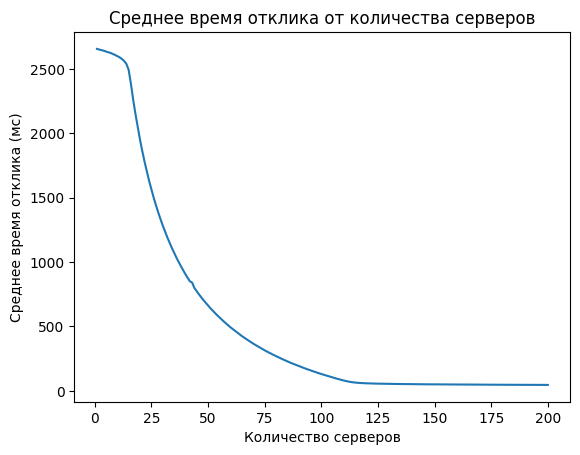

In [29]:
title = 'Среднее время отклика от количества серверов'
        
plt.ylabel('Среднее время отклика (мс)')
plt.xlabel('Количество серверов')
plt.title(title)

plt.plot(servers_num, response_times)

plt.show()

In [30]:
normalized_response_times = normalize_values(response_times)
normalized_servers_num = normalize_values(servers_num)

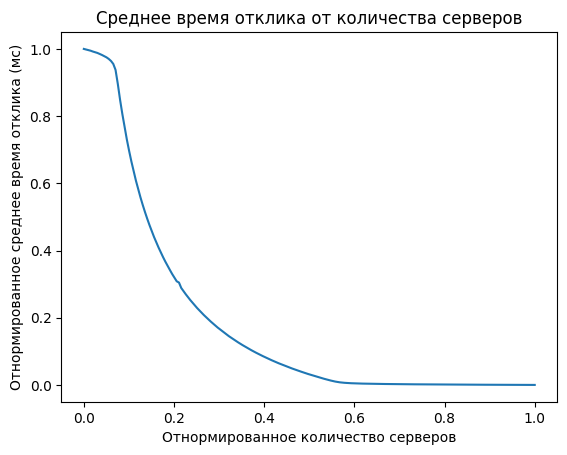

In [31]:
title = 'Среднее время отклика от количества серверов'
        
plt.ylabel('Отнормированное среднее время отклика (мс)')
plt.xlabel('Отнормированное количество серверов')
plt.title(title)

plt.plot(normalized_servers_num, normalized_response_times)

plt.show()

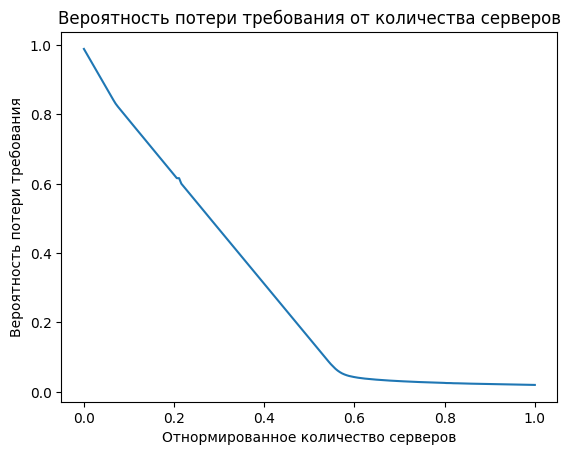

In [20]:
title = 'Вероятность потери требования от количества серверов'
        
plt.ylabel('Вероятность потери требования')
plt.xlabel('Отнормированное количество серверов')
plt.title(title)

plt.plot(normalized_servers_num, loss_probabilities)

plt.show()

In [32]:
ideal_point = (0, 0, 0)
ideal_point_method_result = ideal_point_method(normalized_servers_num, normalized_response_times, loss_probabilities, (0, 0, 0))

optimal_index = np.argmin(ideal_point_method_result)

optimal_number_of_servers = servers_num[optimal_index]
optimal_response_time = response_times[optimal_index]
optimal_loss_probability = loss_probabilities[optimal_index]

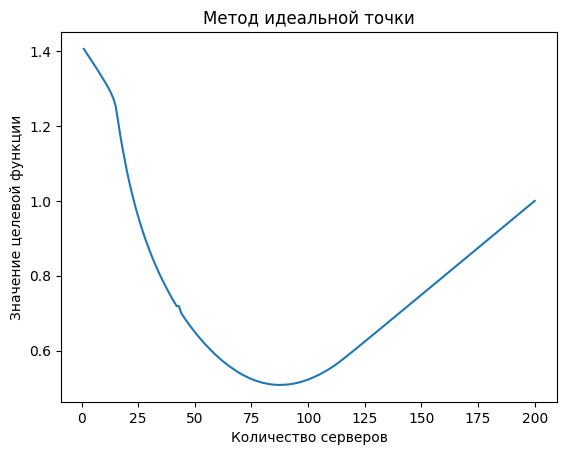

In [33]:
plt.title('Метод идеальной точки')

plt.ylabel('Значение целевой функции')
plt.xlabel('Количество серверов')

plt.plot(servers_num, ideal_point_method_result)

plt.show()

In [23]:
print(f'Оптимальное число серверов: {optimal_number_of_servers}')
print(f'Время отклика: {optimal_response_time}')
print(f'Вероятность потери заявки: {optimal_loss_probability}')

Оптимальное число серверов: 87
Время отклика: 214.01650850571315
Вероятность потери заявки: 0.25980890358745207


In [24]:
weights = (0.1, 0.6, 0.3)

linear_convolution_result = linear_convolution(normalized_servers_num, normalized_response_times, loss_probabilities, weights)

optimal_index = np.argmin(linear_convolution_result)

optimal_number_of_servers = servers_num[optimal_index]
optimal_response_time = response_times[optimal_index]
optimal_loss_probability = loss_probabilities[optimal_index]

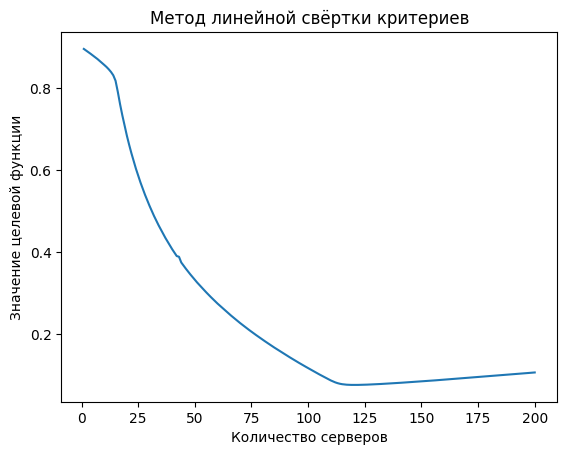

In [25]:
plt.title('Метод линейной свёртки критериев')

plt.ylabel('Значение целевой функции')
plt.xlabel('Количество серверов')

plt.plot(servers_num, linear_convolution_result)

plt.show()

In [26]:
print(f'Оптимальное число серверов: {optimal_number_of_servers}')
print(f'Среднее время отклика: {optimal_response_time}')
print(f'Вероятность потери заявки: {optimal_loss_probability}')

Оптимальное число серверов: 121
Среднее время отклика: 57.668165747368626
Вероятность потери заявки: 0.041407894803026354
